In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the path to the data directory
data_path = './data' # Or wherever you unzipped the files

# Load the datasets
print("Loading datasets...")
aisles_df = pd.read_csv(os.path.join(data_path, 'aisles.csv'))
departments_df = pd.read_csv(os.path.join(data_path, 'departments.csv'))
orders_df = pd.read_csv(os.path.join(data_path, 'orders.csv'))
products_df = pd.read_csv(os.path.join(data_path, 'products.csv'))
order_products_prior_df = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'))
order_products_train_df = pd.read_csv(os.path.join(data_path, 'order_products__train.csv'))
print("Datasets loaded.")

# --- Initial Exploration ---

print("\n--- Aisles Info ---")
aisles_df.info()
print(aisles_df.head())

print("\n--- Departments Info ---")
departments_df.info()
print(departments_df.head())

print("\n--- Orders Info ---")
orders_df.info()
print(orders_df.head())
# Check missing values specifically for days_since_prior_order (expected for first orders)
print(f"Missing days_since_prior_order: {orders_df['days_since_prior_order'].isnull().sum()}")
# Check how many orders belong to train/test/prior sets
print(f"Order eval_set distribution:\n{orders_df['eval_set'].value_counts()}")


print("\n--- Products Info ---")
products_df.info()
print(products_df.head())

print("\n--- Order Products Prior Info ---")
order_products_prior_df.info() # This might take a moment, it's large
print(order_products_prior_df.head())

print("\n--- Order Products Train Info ---")
order_products_train_df.info()
print(order_products_train_df.head())

Loading datasets...
Datasets loaded.

--- Aisles Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

--- Departments Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes
   department_id department
0            

In [8]:
# --- Target Variable Creation (Predict New Product Purchase) ---

# Step 1: Identify Users with a 'Train' Order
print("\nStep 1: Identifying Train Users...")
train_user_ids = orders_df[orders_df['eval_set'] == 'train']['user_id'].unique()
print(f"Number of users in the training set: {len(train_user_ids)}")

# Get the specific order_id for each user's train order
train_orders = orders_df[(orders_df['user_id'].isin(train_user_ids)) & (orders_df['eval_set'] == 'train')]
print(f"Number of 'train' orders: {len(train_orders)}")
# print(train_orders.head()) # Keep output concise for now

# Step 2: Get Products in Each 'Train' Order
print("\nStep 2: Getting Products in Train Orders...")
# Merge train orders with their products
train_order_details = pd.merge(train_orders[['order_id', 'user_id']], order_products_train_df[['order_id', 'product_id']], on='order_id', how='left')
# Handle potential empty train orders (though unlikely in this dataset)
train_order_details['product_id'] = train_order_details['product_id'].fillna(-1) # Use -1 or similar placeholder if needed

print(f"Number of rows in train_order_details: {len(train_order_details)}")

# Create a set of products for each train order_id for quick lookup
# Group by user_id directly as each train user has only one train order
train_products_by_user = train_order_details.groupby('user_id')['product_id'].apply(set).reset_index()
train_products_by_user.rename(columns={'product_id': 'train_product_set'}, inplace=True)

print(f"Number of users mapped to train product sets: {len(train_products_by_user)}")
# print("\nProducts sets for train users (first few):")
# print(train_products_by_user.head())

# Step 3: Get Historical (Prior) Products for Each Train User
print("\nStep 3: Getting Prior Products for Train Users...")
# Get all 'prior' orders for the users who are in the train set
prior_orders_for_train_users = orders_df[(orders_df['user_id'].isin(train_user_ids)) & (orders_df['eval_set'] == 'prior')]
print(f"Number of prior orders from train users: {len(prior_orders_for_train_users)}")

# Merge with prior order products
# Select only necessary columns for efficiency
prior_order_details = pd.merge(
    prior_orders_for_train_users[['order_id', 'user_id']],
    order_products_prior_df[['order_id', 'product_id']],
    on='order_id',
    how='inner'
)
print(f"Total prior order-product entries for train users: {len(prior_order_details)}")

# Get the set of unique products ever purchased by each user in their prior history
# This can be memory intensive, do it efficiently
user_prior_products = prior_order_details.groupby('user_id')['product_id'].apply(set).reset_index()
user_prior_products.rename(columns={'product_id': 'prior_product_set'}, inplace=True)

# Free up memory from the large intermediate dataframe
del prior_order_details
del prior_orders_for_train_users
import gc
gc.collect()

print(f"Number of users mapped to prior product sets: {len(user_prior_products)}")
# print("\nUnique historical products per user (first few):")
# print(user_prior_products.head())

# Step 4: Create the Target Variable y
print("\nStep 4: Creating the Target Variable...")
# Merge the user's train product set and prior product set
# Use train_products_by_user which already has user_id and train_product_set
user_target_data = pd.merge(train_products_by_user, user_prior_products, on='user_id', how='left')

# Handle cases where a user might *only* have a 'train' order (no prior history)
# These users definitely bought 'new' products relative to their (empty) history.
# The 'left' merge already handled users present in train_products_by_user but not user_prior_products
# Their 'prior_product_set' will be NaN. We'll fillna with empty sets.
user_target_data['prior_product_set'] = user_target_data['prior_product_set'].apply(lambda x: x if isinstance(x, set) else set())

print(f"Number of users in target data: {len(user_target_data)}")
# print("\nUser data with train and prior product sets (first few):")
# print(user_target_data.head())

# Define the function to check for new products
def check_for_new_products(row):
    train_set = row['train_product_set']
    prior_set = row['prior_product_set']
    # Handle the placeholder if we used one for empty train orders
    if -1 in train_set:
        train_set.remove(-1)
        if not train_set: # If -1 was the only thing, the order was empty
             return 0 # Or decide how to handle this edge case

    # Calculate the difference: products in train_set but not in prior_set
    new_products = train_set.difference(prior_set)
    # Return 1 if there's at least one new product, 0 otherwise
    return 1 if len(new_products) > 0 else 0

# Apply the function to create the target column 'new_product_purchased'
print("Applying function to calculate target...")
user_target_data['new_product_purchased'] = user_target_data.apply(check_for_new_products, axis=1)

# Select the columns we need for the target definition: user_id and the target
final_target = user_target_data[['user_id', 'new_product_purchased']].copy()

# Free up memory
del user_target_data
del train_products_by_user
del user_prior_products
gc.collect()

print("\nFinal target variable per user (first few):")
print(final_target.head())

# Check the distribution of the target variable
print("\nTarget variable distribution:")
target_distribution = final_target['new_product_purchased'].value_counts(normalize=True) * 100
print(target_distribution)


Step 1: Identifying Train Users...
Number of users in the training set: 131209
Number of 'train' orders: 131209

Step 2: Getting Products in Train Orders...
Number of rows in train_order_details: 1384617
Number of users mapped to train product sets: 131209

Step 3: Getting Prior Products for Train Users...
Number of prior orders from train users: 2047377
Total prior order-product entries for train users: 20641991
Number of users mapped to prior product sets: 131209

Step 4: Creating the Target Variable...
Number of users in target data: 131209
Applying function to calculate target...

Final target variable per user (first few):
   user_id  new_product_purchased
0        1                      1
1        2                      1
2        5                      1
3        7                      1
4        8                      1

Target variable distribution:
new_product_purchased
1    81.555381
0    18.444619
Name: proportion, dtype: float64


In [9]:
print("\n--- Feature Engineering ---")

# Ensure we are working only with users who have a 'train' order defined previously
# train_user_ids = final_target['user_id'].unique() # Should already be defined

# --- Features from orders.csv ---
print("Calculating features from orders data...")

# Filter orders to only prior orders of the relevant users
orders_prior_df = orders_df[orders_df['eval_set'] == 'prior'].copy()
orders_prior_for_train_users_df = orders_prior_df[orders_prior_df['user_id'].isin(train_user_ids)]

# Calculate basic user stats
user_features_orders = orders_prior_for_train_users_df.groupby('user_id').agg(
    user_total_orders=('order_number', 'max'), # Max order number is total prior orders
    user_avg_days_since_prior=('days_since_prior_order', 'mean'),
    user_std_days_since_prior=('days_since_prior_order', 'std'),
    user_sum_days_since_prior=('days_since_prior_order', 'sum') # Useful if avg is NaN for users with only 1 prior order
).reset_index()

# Handle potential NaNs for users with only 1 or 2 prior orders
user_features_orders['user_std_days_since_prior'].fillna(0, inplace=True)
# If avg is NaN (only 1 prior order), sum is also NaN. Let's fill avg with a default, e.g., 0 or a global mean?
# A simple approach is to fill with 0, implying no history of gaps yet.
user_features_orders['user_avg_days_since_prior'].fillna(0, inplace=True)


print("User features from orders data (first few):")
print(user_features_orders.head())
print(f"Shape: {user_features_orders.shape}")


# --- Features related to order contents (requires merging) ---
print("\nCalculating features from order products data...")

# Merge prior order details (takes memory!)
# Make sure order_products_prior_df is loaded
prior_details_merged = pd.merge(
    orders_prior_for_train_users_df[['order_id', 'user_id']],
    order_products_prior_df[['order_id', 'product_id', 'reordered']],
    on='order_id',
    how='inner'
)

# Calculate basket sizes per order first
basket_sizes = prior_details_merged.groupby(['user_id', 'order_id'])['product_id'].count().reset_index(name='order_basket_size')

# Now aggregate basket sizes per user
user_basket_stats = basket_sizes.groupby('user_id')['order_basket_size'].agg(
    user_avg_basket_size='mean',
    user_std_basket_size='std'
).reset_index()
user_basket_stats['user_std_basket_size'].fillna(0, inplace=True) # Fill NaN for users with only 1 prior order

# Calculate overall product interaction stats
user_product_stats = prior_details_merged.groupby('user_id').agg(
    user_total_items_purchased=('product_id', 'count'),
    user_total_unique_items=('product_id', 'nunique'),
    user_reorder_sum=('reordered', 'sum') # Sum of reordered flags
).reset_index()

# Calculate reorder ratio
user_product_stats['user_reorder_ratio'] = user_product_stats['user_reorder_sum'] / user_product_stats['user_total_items_purchased']
# Handle potential division by zero if a user somehow has 0 items (unlikely but safe)
user_product_stats['user_reorder_ratio'].fillna(0, inplace=True)

print("User basket size features (first few):")
print(user_basket_stats.head())
print(f"Shape: {user_basket_stats.shape}")

print("\nUser product interaction features (first few):")
print(user_product_stats.head())
print(f"Shape: {user_product_stats.shape}")


# --- Combine Features ---
print("\nCombining features...")

# Start with the base user list and target
final_model_data = final_target.copy()

# Merge order features
final_model_data = pd.merge(final_model_data, user_features_orders, on='user_id', how='left')
# Merge basket features
final_model_data = pd.merge(final_model_data, user_basket_stats, on='user_id', how='left')
# Merge product interaction features
final_model_data = pd.merge(final_model_data, user_product_stats, on='user_id', how='left')

print("Final combined data for modeling (first few rows):")
print(final_model_data.head())
print(f"Shape: {final_model_data.shape}")

# Check for any NaNs introduced by merges (shouldn't happen with left merge on user_id if all users were processed)
print("\nMissing values in combined data:")
print(final_model_data.isnull().sum())

# Optional: Save the features + target dataframe
# feature_save_path = os.path.join(data_path, 'model_ready_data_new_product.csv')
# final_model_data.to_csv(feature_save_path, index=False)
# print(f"\nModel-ready data saved to {feature_save_path}")

# Clean up large intermediate frames
del prior_details_merged
del basket_sizes
del user_features_orders
del user_basket_stats
del user_product_stats
gc.collect()


--- Feature Engineering ---
Calculating features from orders data...


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_24688/1651890427.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_features_orders['user_std_days_since_prior'].fillna(0, inplace=True)
/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_24688/1651890427.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

User features from orders data (first few):
   user_id  user_total_orders  user_avg_days_since_prior  \
0        1                 10                  19.555556   
1        2                 14                  15.230769   
2        5                  4                  13.333333   
3        7                 20                  10.684211   
4        8                  3                  30.000000   

   user_std_days_since_prior  user_sum_days_since_prior  
0                   9.395625                      176.0  
1                   9.867065                      198.0  
2                   4.932883                       40.0  
3                   8.963213                      203.0  
4                   0.000000                       60.0  
Shape: (131209, 5)

Calculating features from order products data...


/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_24688/1651890427.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_basket_stats['user_std_basket_size'].fillna(0, inplace=True) # Fill NaN for users with only 1 prior order


User basket size features (first few):
   user_id  user_avg_basket_size  user_std_basket_size
0        1              5.900000              1.523884
1        2             13.928571              5.717238
2        5              9.250000              3.095696
3        7             10.300000              5.894690
4        8             16.333333              4.163332
Shape: (131209, 3)

User product interaction features (first few):
   user_id  user_total_items_purchased  user_total_unique_items  \
0        1                          59                       18   
1        2                         195                      102   
2        5                          37                       23   
3        7                         206                       68   
4        8                          49                       36   

   user_reorder_sum  user_reorder_ratio  
0                41            0.694915  
1                93            0.476923  
2                14            0.37

/var/folders/51/pys4jc71057cwt5cvjb3qqh80000gn/T/ipykernel_24688/1651890427.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_product_stats['user_reorder_ratio'].fillna(0, inplace=True)


0


--- Preparing Data for Modeling ---
Features shape: (131209, 10)
Target shape: (131209,)
Features used: ['user_total_orders', 'user_avg_days_since_prior', 'user_std_days_since_prior', 'user_sum_days_since_prior', 'user_avg_basket_size', 'user_std_basket_size', 'user_total_items_purchased', 'user_total_unique_items', 'user_reorder_sum', 'user_reorder_ratio']

Splitting data into train and test sets...
X_train shape: (104967, 10)
X_test shape: (26242, 10)
y_train distribution:
new_product_purchased
1    0.815552
0    0.184448
Name: proportion, dtype: float64
y_test distribution:
new_product_purchased
1    0.815563
0    0.184437
Name: proportion, dtype: float64

--- Training Logistic Regression Model ---
Logistic Regression training complete.

--- Evaluating Logistic Regression Model ---
Accuracy: 0.8313
Precision: 0.8406
Recall: 0.9788
F1-Score: 0.9045
AUC-ROC: 0.7580

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.18      0.

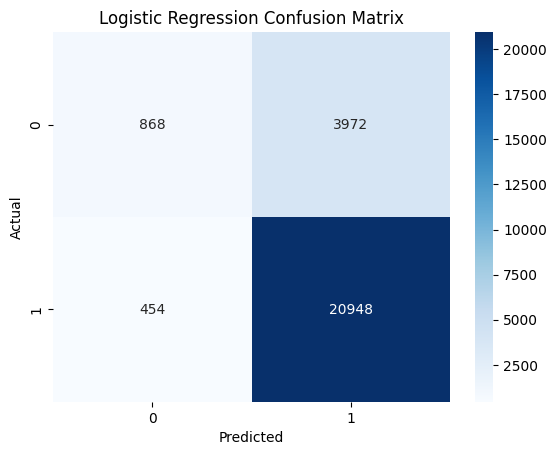


Logistic Regression Coefficients:
                      feature  coefficient  abs_coefficient
9          user_reorder_ratio    -3.813478         3.813478
4        user_avg_basket_size     0.142039         0.142039
5        user_std_basket_size    -0.054117         0.054117
2   user_std_days_since_prior     0.011841         0.011841
1   user_avg_days_since_prior    -0.011264         0.011264
7     user_total_unique_items     0.003984         0.003984
8            user_reorder_sum    -0.002799         0.002799
6  user_total_items_purchased     0.001185         0.001185
3   user_sum_days_since_prior     0.000622         0.000622
0           user_total_orders    -0.000030         0.000030


In [10]:
# --- Model Training and Evaluation ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'final_model_data' is your DataFrame with features and target
# If you saved it earlier, load it back:
# data_path = 'data'
# final_model_data = pd.read_csv(os.path.join(data_path, 'model_ready_data_new_product.csv'))

print("\n--- Preparing Data for Modeling ---")

# Define Features (X) and Target (y)
# Features are all columns except user_id and the target variable
features = final_model_data.drop(columns=['user_id', 'new_product_purchased'])
target = final_model_data['new_product_purchased']

# Get feature names for later use (e.g., feature importance)
feature_names = features.columns.tolist()

print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}")
print(f"Features used: {feature_names}")

# Step 1: Split Data into Training and Testing Sets (Stratified)
print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,        # Using 20% of the data for testing
    random_state=42,      # For reproducibility
    stratify=target       # IMPORTANT for imbalanced datasets!
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")


# --- Baseline Model: Logistic Regression ---
print("\n--- Training Logistic Regression Model ---")

# Initialize the model
# Increase max_iter as the default might be too low for this dataset
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

print("Logistic Regression training complete.")

# Step 4: Evaluate the Baseline Model
print("\n--- Evaluating Logistic Regression Model ---")

# Make predictions on the test set
y_pred_log_reg = log_reg.predict(X_test)
y_pred_proba_log_reg = log_reg.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1)

# Calculate Metrics
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)
roc_auc = roc_auc_score(y_test, y_pred_proba_log_reg)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}") # How many predicted positives were actually positive?
print(f"Recall: {recall:.4f}")    # How many actual positives were correctly identified?
print(f"F1-Score: {f1:.4f}")   # Harmonic mean of precision and recall
print(f"AUC-ROC: {roc_auc:.4f}")    # Ability to distinguish between classes

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Optional: Look at Feature Importance (Coefficients for LogReg)
# Note: Coefficients are more interpretable if features are scaled, which we haven't done yet.
# But we can see the direction and magnitude.
print("\nLogistic Regression Coefficients:")
coefficients = pd.DataFrame({'feature': feature_names, 'coefficient': log_reg.coef_[0]})
coefficients['abs_coefficient'] = abs(coefficients['coefficient'])
print(coefficients.sort_values(by='abs_coefficient', ascending=False))


--- Training Random Forest Model ---
Random Forest training complete. Time taken: 2.78 seconds

--- Evaluating Random Forest Model ---
Accuracy: 0.8228
Precision: 0.8427
Recall: 0.9624
F1-Score: 0.8985
AUC-ROC: 0.7274

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.21      0.30      4840
           1       0.84      0.96      0.90     21402

    accuracy                           0.82     26242
   macro avg       0.70      0.58      0.60     26242
weighted avg       0.79      0.82      0.79     26242


Confusion Matrix:


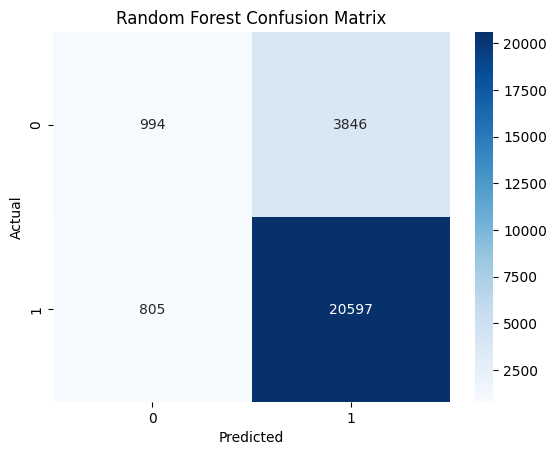


Random Forest Feature Importances:
                      feature  importance
9          user_reorder_ratio    0.163100
4        user_avg_basket_size    0.135511
5        user_std_basket_size    0.126888
2   user_std_days_since_prior    0.105597
1   user_avg_days_since_prior    0.097079
3   user_sum_days_since_prior    0.094168
7     user_total_unique_items    0.087555
6  user_total_items_purchased    0.070260
8            user_reorder_sum    0.067633
0           user_total_orders    0.052208


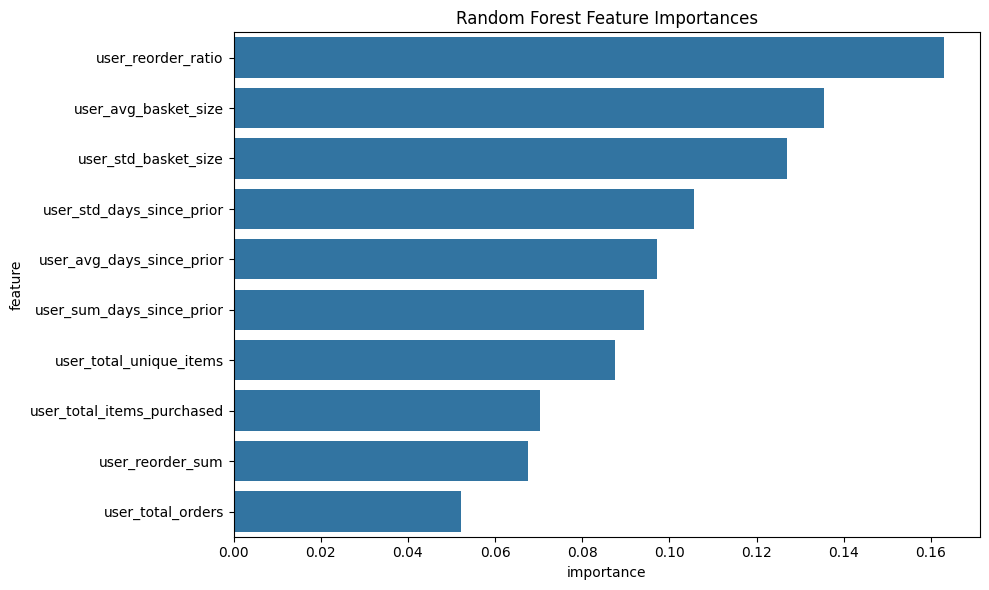

In [11]:
# --- Random Forest Model ---
from sklearn.ensemble import RandomForestClassifier
import time # To time the training

print("\n--- Training Random Forest Model ---")

# Initialize the model
# n_estimators: number of trees in the forest
# random_state: for reproducibility
# n_jobs=-1: use all available CPU cores (can speed up training but uses more memory)
# class_weight='balanced': Useful for imbalanced data, automatically adjusts weights inversely proportional to class frequencies
rf_model = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  n_jobs=-1,
                                  class_weight='balanced') # Try 'balanced' due to imbalance

# Time the training process
start_time = time.time()

# Train the model
rf_model.fit(X_train, y_train)

end_time = time.time()
print(f"Random Forest training complete. Time taken: {end_time - start_time:.2f} seconds")

# --- Evaluating Random Forest Model ---
print("\n--- Evaluating Random Forest Model ---")

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1)

# Calculate Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")
print(f"AUC-ROC: {roc_auc_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# --- Feature Importance ---
print("\nRandom Forest Feature Importances:")
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()


--- Training XGBoost Model ---
Calculated scale_pos_weight: 0.2262


/Users/chidiogoonoh/Projects/kaggle/instacart/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:58:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete. Time taken: 0.31 seconds

--- Evaluating XGBoost Model ---
Accuracy: 0.7156
Precision: 0.9001
Recall: 0.7326
F1-Score: 0.8078
AUC-ROC: 0.7525

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.64      0.45      4840
           1       0.90      0.73      0.81     21402

    accuracy                           0.72     26242
   macro avg       0.63      0.69      0.63     26242
weighted avg       0.80      0.72      0.74     26242


Confusion Matrix:


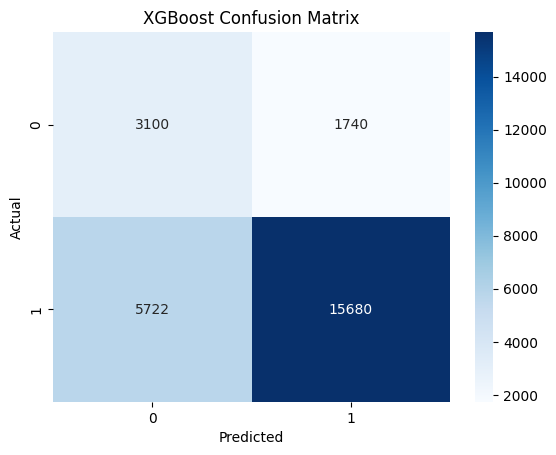


XGBoost Feature Importances:
                      feature  importance
9          user_reorder_ratio    0.347685
4        user_avg_basket_size    0.279679
7     user_total_unique_items    0.058845
5        user_std_basket_size    0.049048
6  user_total_items_purchased    0.045760
2   user_std_days_since_prior    0.045497
1   user_avg_days_since_prior    0.044909
3   user_sum_days_since_prior    0.044893
8            user_reorder_sum    0.041927
0           user_total_orders    0.041756


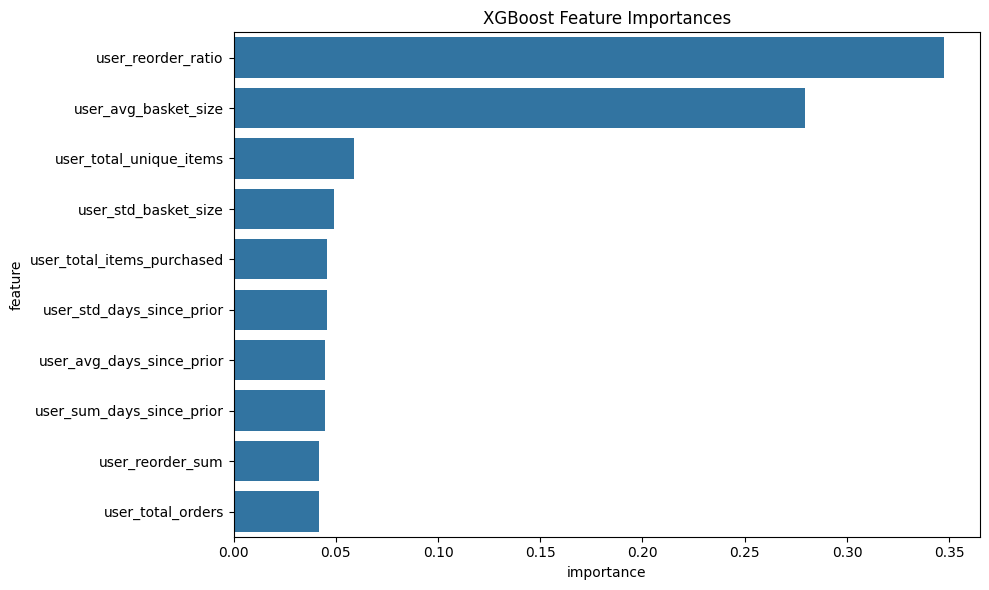

In [12]:
# --- XGBoost Model ---
import xgboost as xgb # Conventionally imported as xgb
import time

print("\n--- Training XGBoost Model ---")

# Calculate scale_pos_weight for imbalance handling
# scale_pos_weight = count(negative examples) / count(positive examples)
count_neg = y_train.value_counts()[0]
count_pos = y_train.value_counts()[1]
scale_pos_weight_value = count_neg / count_pos
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.4f}")

# Initialize the XGBoost classifier
# objective='binary:logistic': for binary classification, outputs probabilities
# eval_metric='logloss': evaluation metric during training (can also use 'auc')
# use_label_encoder=False: Avoids a potential warning in newer versions
# n_estimators: number of boosting rounds/trees
# random_state: for reproducibility
# n_jobs=-1: use all cores
# scale_pos_weight: handles class imbalance
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='logloss',
                              use_label_encoder=False,
                              n_estimators=100,
                              scale_pos_weight=scale_pos_weight_value,
                              random_state=42,
                              n_jobs=-1)

# Time the training process
start_time = time.time()

# Train the model
xgb_model.fit(X_train, y_train)

end_time = time.time()
print(f"XGBoost training complete. Time taken: {end_time - start_time:.2f} seconds")


# --- Evaluating XGBoost Model ---
print("\n--- Evaluating XGBoost Model ---")

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (1)

# Calculate Metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {roc_auc_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# --- Feature Importance ---
print("\nXGBoost Feature Importances:")
# XGBoost provides importance based on 'weight', 'gain', 'cover' etc.
# 'weight' is the number of times a feature appears in a tree
# 'gain' is the average gain of splits which use the feature (often useful)
importances = xgb_model.feature_importances_ # Default importance type ('weight') or specify type in get_score
feature_importance_xgb_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_xgb_df = feature_importance_xgb_df.sort_values(by='importance', ascending=False)
print(feature_importance_xgb_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_xgb_df)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()